In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import transforms
import torch.optim as optim
from torch import nn
from tqdm.notebook import tqdm
from torchsummary import summary
from torchvision import datasets
from torchvision import transforms


from utils import read_machine_data_cvae
from utils import softclip
#from utils import plot_train_test_reconstructions, plot_train_test_reconstructions_cvae
from models.cnn_sigmacVAE import CNN_sigmacVAE

import evaluation_utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [26]:
window_size = 24
cond_window_size = 8
batch_size=256

X_train_data, X_test_data, X_train_tensor, cond_train_tensor, X_test_tensor, cond_test_tensor, trainloader, testloader = read_machine_data_cvae('../../datasets/ServerMachineDataset/machine-1-1', window_size, cond_window_size, batch_size)

In [3]:
def train_model(model, num_epochs, learning_rate, dataloader):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    epochs=num_epochs
    tq = tqdm(range(epochs))
    for epoch in tq:
        flag = False
        for j, data in enumerate(dataloader, 0):

            model.train()
            
            optimizer.zero_grad()

            #batches
            inputs, cond = data
            inputs.to(device)
            cond.to(device)

            outputs, rec_mu, rec_sigma, kl = model(inputs, cond)

            rec_comps, rec, rec_mu_sigma_loss, kl = model.loss_function(outputs, inputs, rec_mu, rec_sigma, kl)

            loss = rec + kl + rec_mu_sigma_loss

            if(np.isnan(loss.item())):
                print("Noped out at", epoch, j, kl, rec_comps)
                flag = True
                break

            loss.backward()
            optimizer.step()
        if(flag):
            break
        tq.set_postfix(loss=loss.item())
        #print(epoch, 'total :' + str(loss.item()) + ' rec : ' + str(rec.item()) + ' kl : ' + str(kl.sum().item()) + ' sigma: ' + str(model.log_sigma.item()))

        #break
    return model

In [4]:
latent_dim=8
model = CNN_sigmacVAE(latent_dim=latent_dim, window_size=window_size, cond_window_size=cond_window_size, use_probabilistic_decoder=False)
model.to(device)
model.cuda() if torch.cuda.is_available() else model.cpu()

model = train_model(model, 100, .005, trainloader)

In [6]:
torch.save(model, 'cvae2d.pth')

In [11]:
print(X_train_data.shape)

(28479, 38)


(28448, 38)
(28479, 38)
(3556, 1, 24, 38)


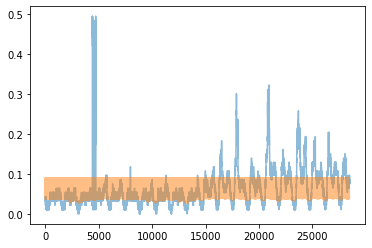

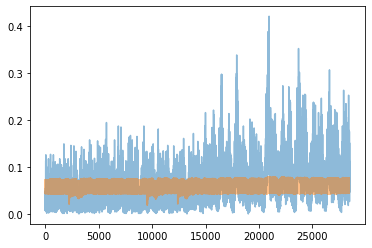

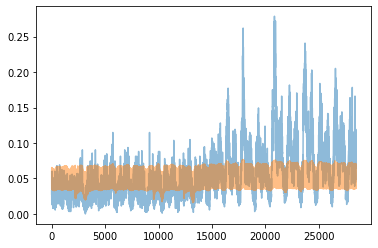

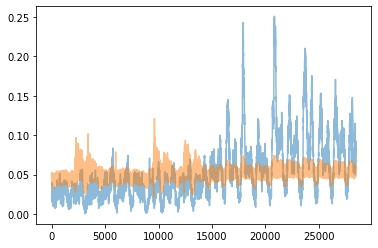

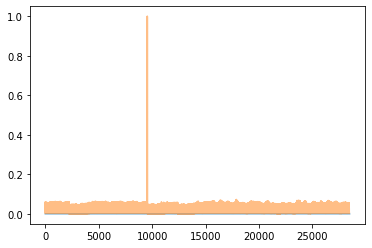

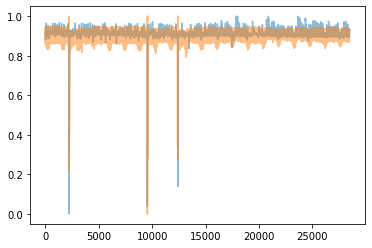

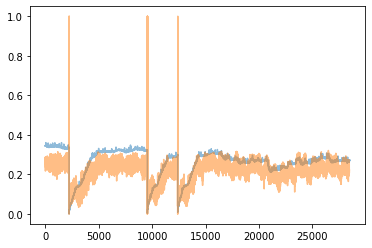

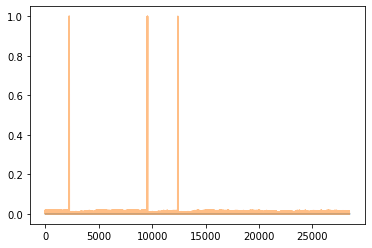

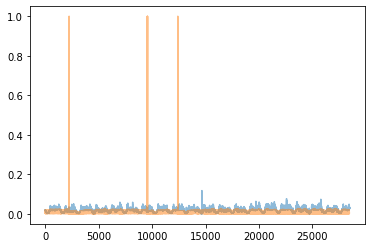

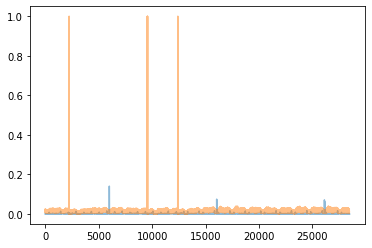

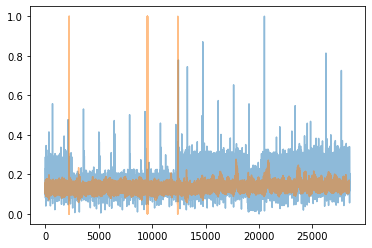

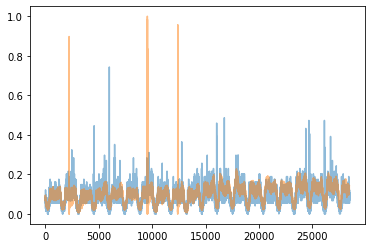

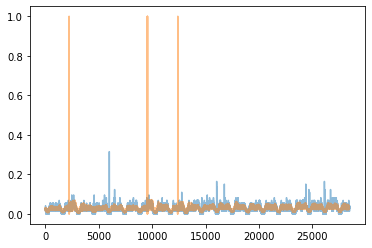

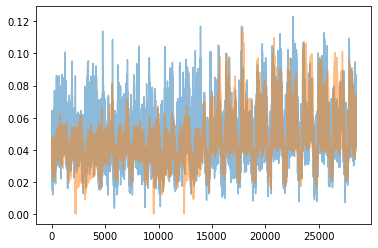

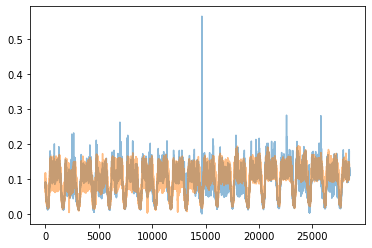

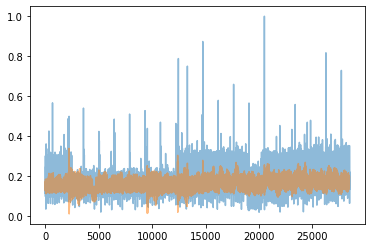

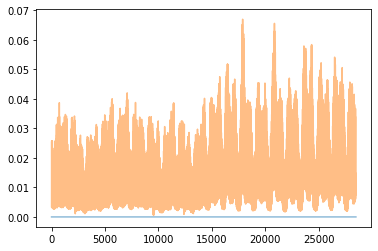

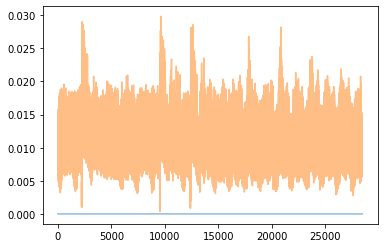

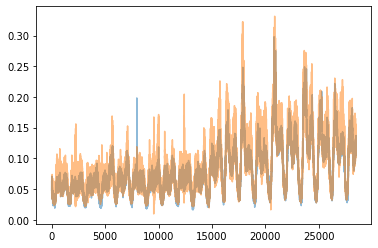

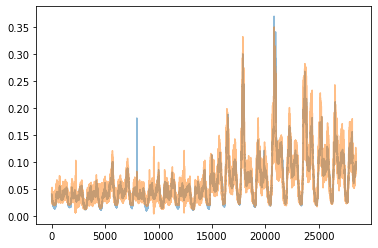

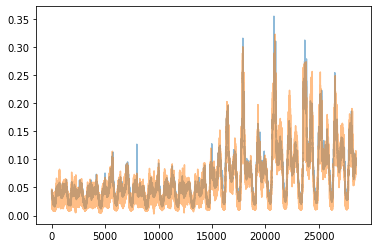

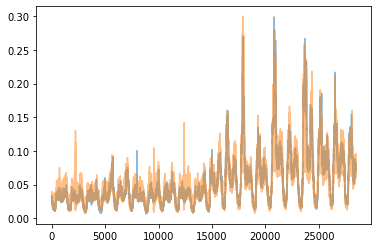

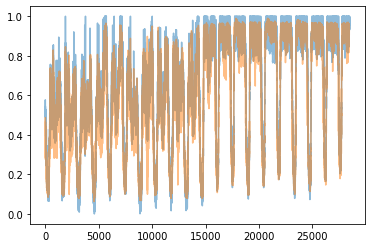

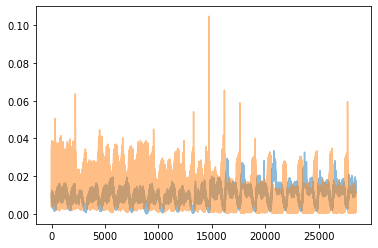

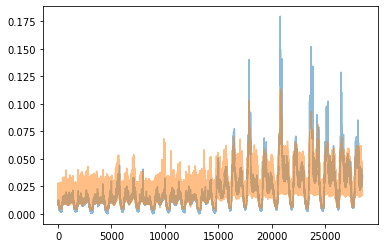

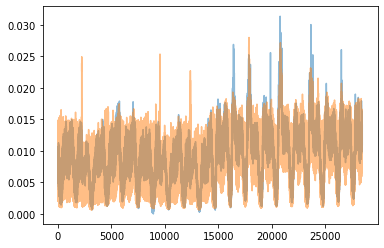

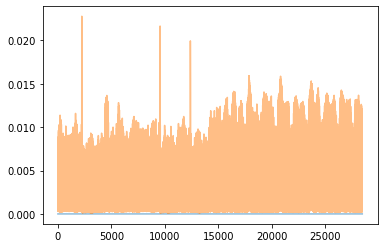

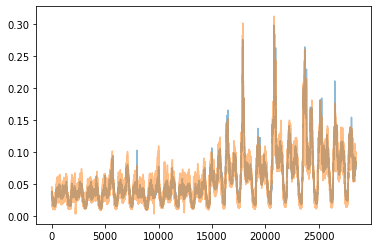

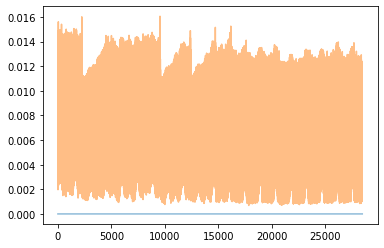

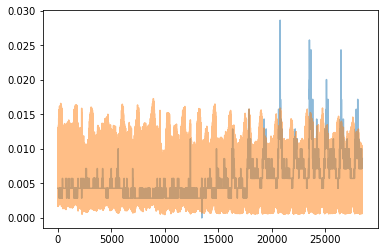

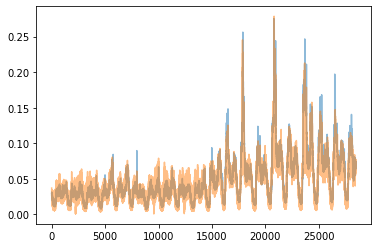

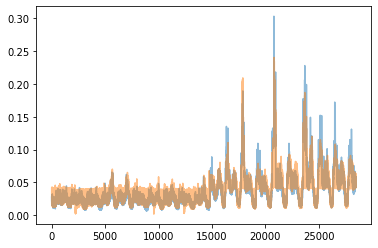

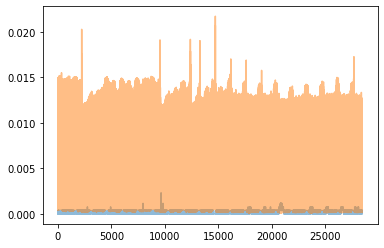

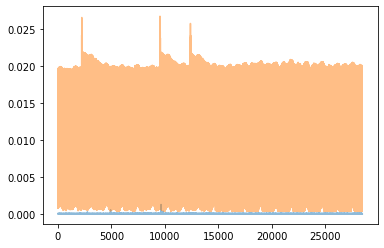

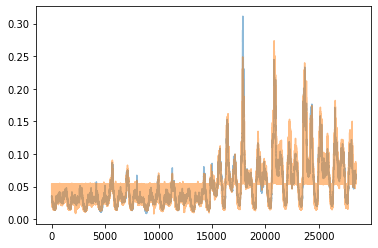

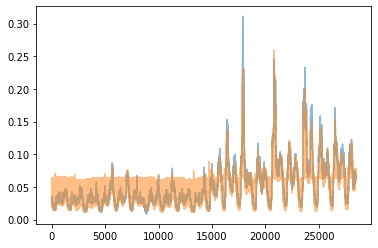

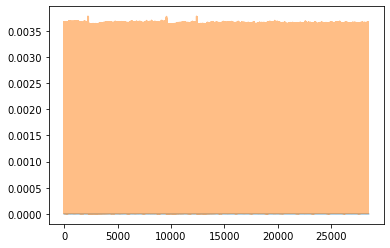

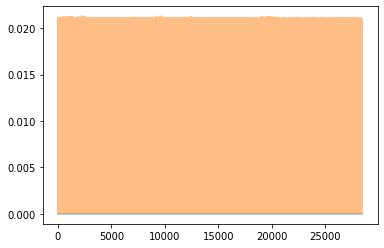

MSE : 0.00088


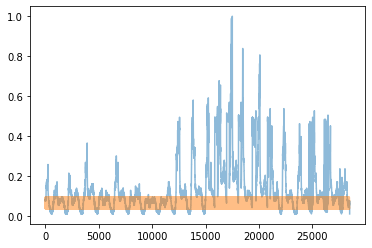

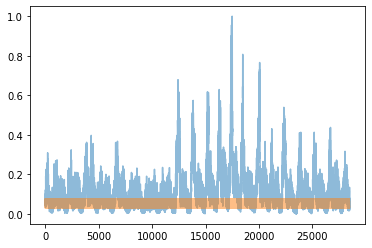

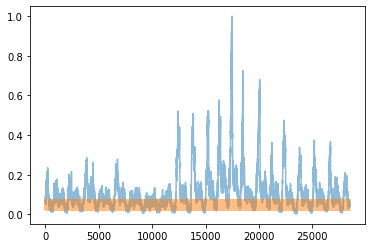

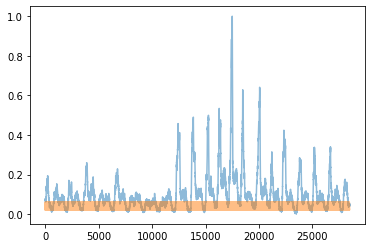

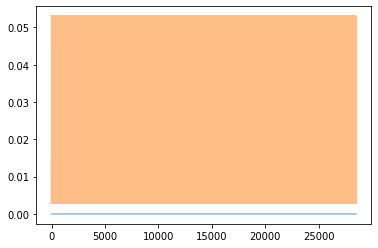

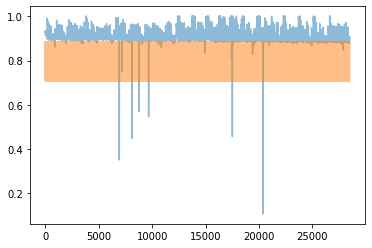

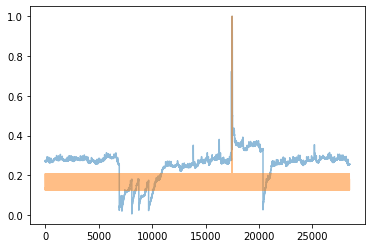

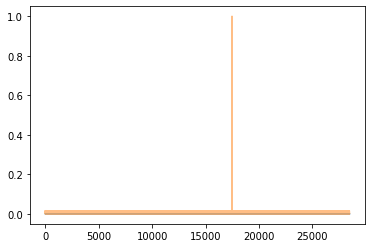

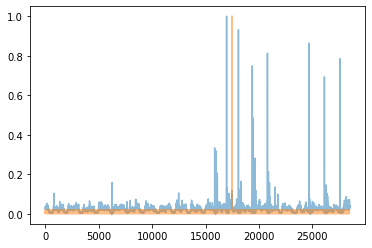

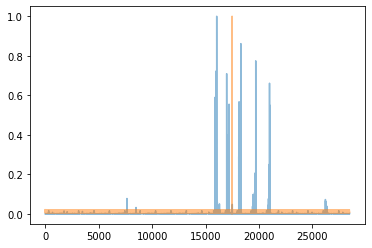

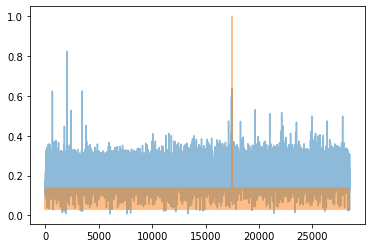

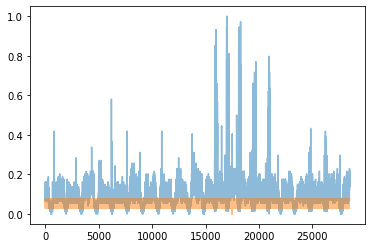

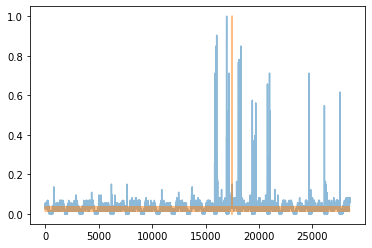

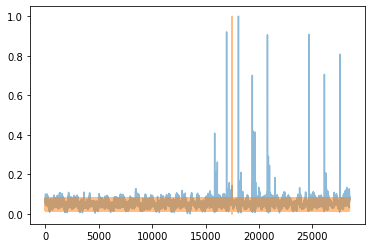

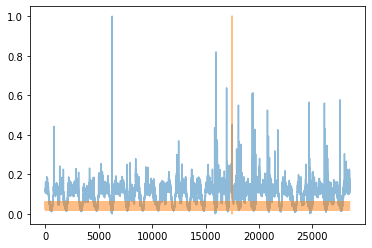

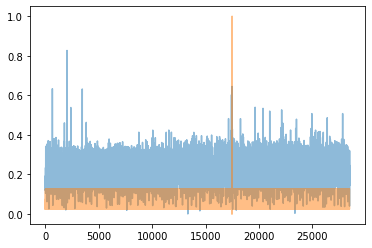

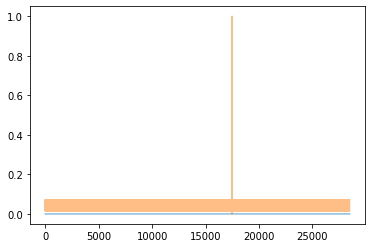

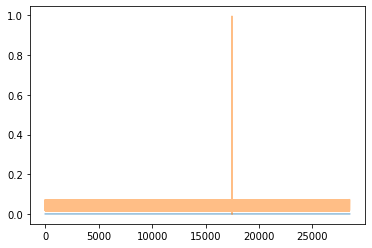

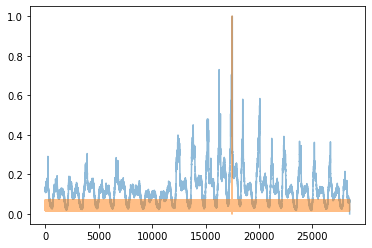

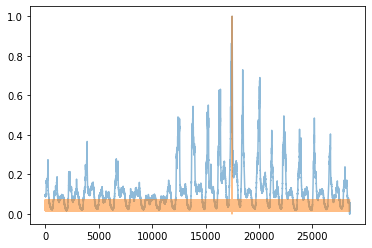

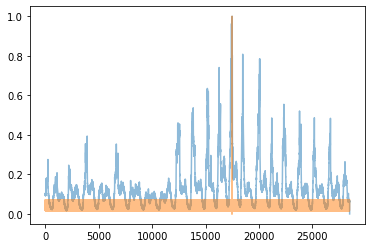

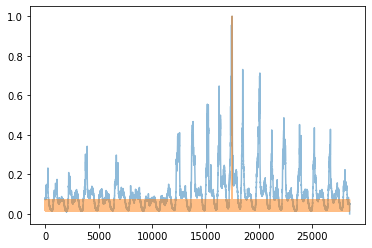

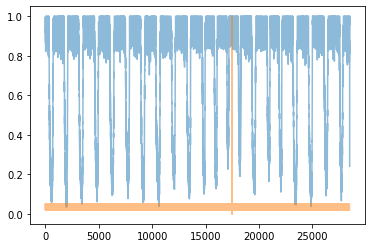

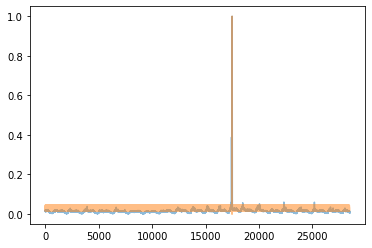

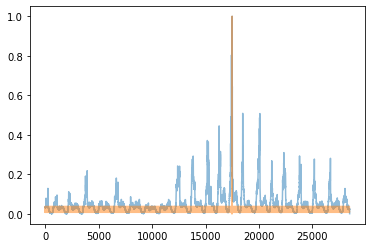

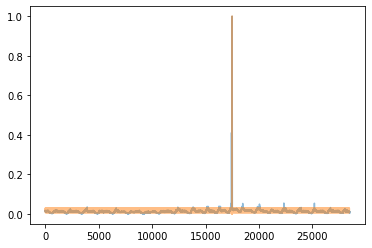

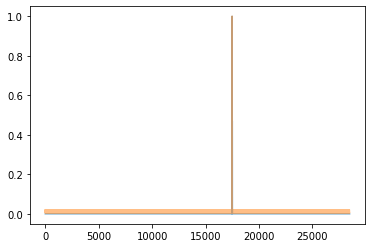

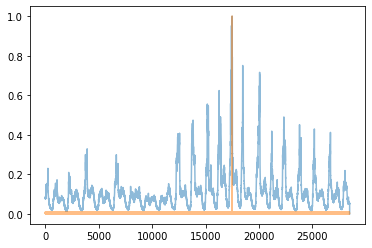

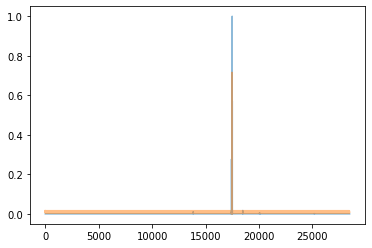

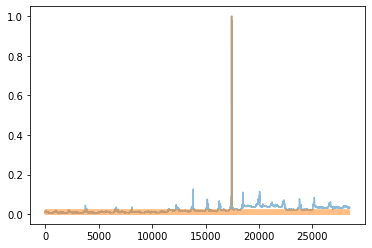

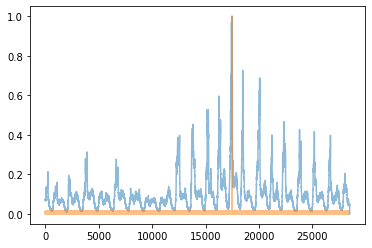

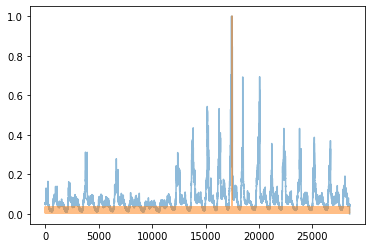

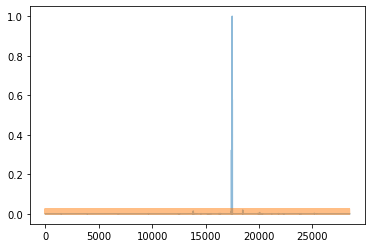

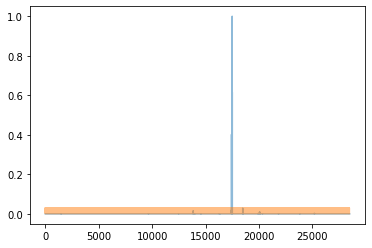

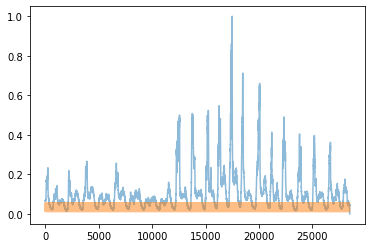

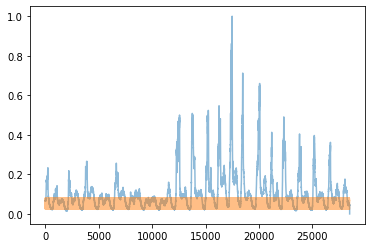

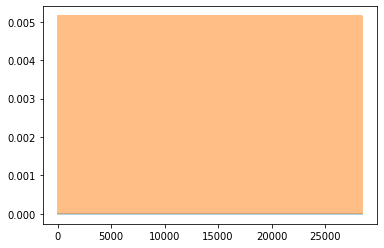

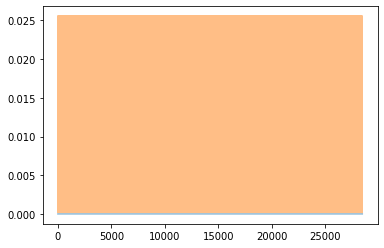

MSE : 0.02589


In [34]:
from sklearn.metrics import mean_squared_error


def plot_train_test_reconstructions_cvae(model, X_train_tensor, X_train_data, X_test_tensor, X_test_data, cond_train_tensor, cond_test_tensor, window_size, cond_window_size):
    torch.no_grad()
    
    X_train_tensor = X_train_tensor.cuda() if torch.cuda.is_available() else X_train_tensor.cpu()
    X_train_tensor.to(device)
    X_test_tensor = X_test_tensor.cuda() if torch.cuda.is_available() else X_test_tensor.cpu()
    X_test_tensor.to(device)
    cond_train_tensor = cond_train_tensor.cuda() if torch.cuda.is_available() else cond_train_tensor.cpu()
    cond_train_tensor.to(device)
    cond_test_tensor = cond_test_tensor.cuda() if torch.cuda.is_available() else cond_test_tensor.cpu()
    cond_test_tensor.to(device)
    
    
    #train data
    out_pred, _,_,_= model(X_train_tensor, cond_train_tensor)
    out_pred = out_pred.cpu().detach().numpy()
        
        
    idx = 0
    preds=np.zeros((out_pred.shape[0]*cond_window_size, out_pred.shape[3]))
    
    print(preds.shape)
    print(X_train_data.shape)
    print(out_pred.shape)
    
    time_idx=0
    for i in range(len(out_pred)):
        preds[time_idx:time_idx+cond_window_size, :] = out_pred[i, 0, :cond_window_size, :]
        time_idx += cond_window_size
    
    for i in range(preds.shape[1]):
        plt.figure()
        plt.plot(X_train_data[:, i],alpha=.5)
        plt.plot(preds[:, i],alpha=.5)
        plt.show()

    mse = mean_squared_error(X_train_data[:len(preds), :], preds)
    print('MSE : ' + str(np.round(mse,5)))
    
    
    #test data
    out_pred, _,_,_= model(X_test_tensor, cond_test_tensor)
    out_pred = out_pred.cpu().detach().numpy()

    idx = 0
    preds=np.zeros((out_pred.shape[0]*cond_window_size, out_pred.shape[3]))
    
    time_idx=0
    for i in range(len(out_pred)):
        preds[time_idx:time_idx+cond_window_size, :] = out_pred[i, 0, :cond_window_size, :]
        time_idx += cond_window_size
    
    for i in range(preds.shape[1]):
        plt.figure()
        plt.plot(X_test_data[:, i],alpha=.5)
        plt.plot(preds[:, i],alpha=.5)
        plt.show()

    mse = mean_squared_error(X_test_data[:len(preds), :], preds)
    print('MSE : ' + str(np.round(mse,5)))


plot_train_test_reconstructions_cvae(model, X_train_tensor, X_train_data, X_test_tensor, X_test_data, cond_train_tensor, cond_test_tensor, window_size, cond_window_size)

In [35]:
cond_test_tensor.shape

torch.Size([3557, 1, 8, 38])

(28456,)
(28456, 38)
Computing AUPR for 28456 thresholds ... 


c:\python37\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


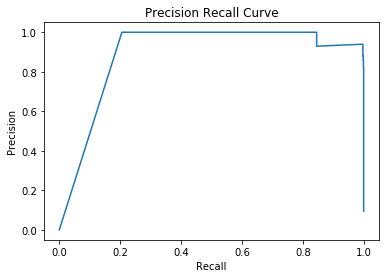


--- AUPR ---
0.8868599567350582
Best F1 score : 0.9675909254591285 at threshold : -0.07904377527677311 (1-percentile : 0.032409074540871496)
Corresponding best precision : 0.9395104895104895, best recall : 0.9974016332590943

--- Metrics ---
precision : 0.7977494817885697 recall : 1.0 f1 : 0.8874979410311317




In [44]:
#anomaly detection

def evaluate_cvae_model(model, X_tensor, c):
    cond_window_size = c.size(2)
    
    X_tensor = X_tensor.cuda() if torch.cuda.is_available() else X_tensor.cpu()
    X_tensor.to(device)
    c = c.cuda() if torch.cuda.is_available() else c.cpu()
    c.to(device)

    out_pred, _,_,_= model(X_tensor, c)
    out_pred = out_pred.cpu().detach().numpy()

    preds=np.zeros((out_pred.shape[0]*cond_window_size, out_pred.shape[3]))
    time_idx=0
    for i in range(len(out_pred)):
        preds[time_idx:time_idx+cond_window_size, :] = out_pred[i, 0, :cond_window_size, :]
        time_idx += cond_window_size
    
    return preds


def cVAE_anomaly_detection(model, X_test_tensor, X_test_data, cond_test_tensor, X_train_data, df_Y_test, initial_quantile_thresh):

    cond_window_size = cond_test_tensor.shape[2]

    #inference
    preds = evaluate_cvae_model(model, X_test_tensor, cond_test_tensor)
    scores = - (np.square(preds - X_test_data[:len(preds)])).mean(axis=1)

    
    real = df_Y_test.values
    real = np.reshape(real, (real.shape[0], ))
    real = real[:len(preds)]
    anomaly_idxs = np.where(real == 1)[0]
    
    print(real.shape)
    print(preds.shape)
    
    
    
    evaluation_utils.compute_AUPR(real, scores)
    
    thresh = np.quantile(scores, initial_quantile_thresh)
    #plot_error_and_anomaly_idxs(X_test_data, preds, scores, anomaly_idxs_test, thresh)
    anomaly_preds = evaluation_utils.evaluate_adjusted_anomalies(real, scores, thresh)
    evaluation_utils.print_metrics(real, anomaly_preds)

cVAE_anomaly_detection(model, X_test_tensor, X_test_data, cond_test_tensor, X_train_data, df_Y_test, .05)
